In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from os import getcwd, listdir
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft,ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
import time
import os.path

from scipy.signal import hilbert, chirp
from neurodsp.filt import filter_signal


In [2]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

In [3]:
def find_full_3_trial(subj_table):
    good_trial = []
    num_sess = len(subj_table['session_id'].unique())
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0]/num_sess == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [4]:
def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])


In [5]:
produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [6]:
dbs_subj = listdir('../../../DBS')
dbs_30s = [i for i in dbs_subj if i.startswith('DBS30')]
len(dbs_30s)

29

In [48]:
def get_all_dbs(SUBJECT, f_low, f_high):
    print(SUBJECT)
    t = time.time()

    f_range = (f_low, f_high)
    csv_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt'

    file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
    subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
    print('Loaded')

    chanlabel = []
    for item in range(subj_mat['label'].shape[0]):
        chanlabel.append(subj_mat['label'][item][0][0][0])
    chanlabel = np.array(chanlabel)

    fs = subj_mat['fsample'][0][0]
    nChans = len(subj_mat['label'])
    nTrials = len(subj_mat['trial'][0])

    dbs_chan = []
    for item in range(nChans):
        if chanlabel[item][:4] == "dbs_":
            dbs_chan.append(item)
    dbs_chan = np.array(dbs_chan)

    time_mat = subj_mat['time'][0]
    trial_mat = subj_mat['trial'][0]

    subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
    subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
    subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

    cue_df = pd.read_csv(csv_path, sep='	', index_col='id')
    subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    print('Start parcellation')
    dbs_mat = np.zeros((subj_df_cue.shape[0], len(dbs_chan), 5000))
    for item in range(subj_df_cue.shape[0]):
        time_point = subj_df_cue.iloc[item].starts_y
        for i2 in range(nTrials):
            time_min = time_mat[i2][0].min()
            time_max = time_mat[i2][0].max()
            if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
                for i3 in range(len(time_mat[i2][0])):
                    if time_mat[i2][0][i3] > time_point:
                        if len(dbs_chan)> 0:
                            sig_filt = trial_mat[i2][dbs_chan]
                            sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                            sig_filt = np.nan_to_num(sig_filt)
                            analytic_signal = hilbert(sig_filt)
                            amplitude_envelope = np.abs(analytic_signal)
                            dbs_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]

                        break
                        break

    
    dbs_mat = dbs_mat.mean(axis=0).T
    if len(dbs_chan) > 0:
        return dbs_mat, dbs_chan, chanlabel[dbs_chan]
    else:
        return dbs_mat, 0, 0

    elapsed = time.time() - t

    print(f'Done subject with {elapsed} seconds')




In [49]:
f_low = 1
f_high = 200

buffer_save = np.zeros((5000, 1))
dbs_channel_info = pd.DataFrame(columns=['Subject', 'Chan name', 'Chan num'])
buffer_save.shape
dbs_channel_info

for subj in dbs_30s:
    csv_path = f'../../../DBS/{subj}/Preprocessed Data/Sync/annot/{subj}_stimulus_syllable.txt'
    if os.path.isfile(csv_path):
        dbs_out, channel_num, channel_label = get_all_dbs(subj, f_low, f_high)
        buffer_save = np.concatenate((buffer_save, dbs_out), axis=1)
        
        if channel_label != 0:
            subject_label = np.repeat(subj, len(channel_num))
            subj_dbs_info = pd.DataFrame({'Subject':subject_label, 'Chan name':channel_label, 'Chan num':channel_num})
            dbs_channel_info = pd.concat([dbs_channel_info, subj_dbs_info])
        print(buffer_save.shape)
        print(dbs_channel_info.shape)
        
buffer_save = buffer_save[:, 1:]


dbs_chan_band = {f'dbs_chan_{f_low}_{f_high}':buffer_save, 'info':dbs_channel_info}
savemat(f'processed_data/dbs_chan_{f_low}_{f_high}.mat', dbs_chan_band)


(5000, 1)

,Subject,Chan name,Chan num


DBS3003
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3004
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3005
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3008
Loaded
Start parcellation
(5000, 21)
(20, 3)
DBS3010
Loaded
Start parcellation
(5000, 29)
(28, 3)
DBS3011
Loaded
Start parcellation
(5000, 37)
(36, 3)
DBS3012
Loaded
Start parcellation
(5000, 41)
(40, 3)
DBS3014
Loaded
Start parcellation
(5000, 57)
(56, 3)
DBS3015
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3016
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3017
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3018
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3019
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3020
Loaded
Start parcellation
(5000, 81)
(80, 3)
DBS3022
Loaded
Start parcellation
(5000, 89)
(88, 3)
DBS3021
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3023
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3024
Loaded
Start parcellation
(5000, 101)
(100, 3)
DBS3025
Loaded
Start parcellation
(5000, 117

In [55]:
f_low = 70
f_high = 150

buffer_save = np.zeros((5000, 1))
dbs_channel_info = pd.DataFrame(columns=['Subject', 'Chan name', 'Chan num'])
buffer_save.shape
dbs_channel_info

for subj in dbs_30s:
    csv_path = f'../../../DBS/{subj}/Preprocessed Data/Sync/annot/{subj}_stimulus_syllable.txt'
    if os.path.isfile(csv_path):
        dbs_out, channel_num, channel_label = get_all_dbs(subj, f_low, f_high)
        buffer_save = np.concatenate((buffer_save, dbs_out), axis=1)
        
        if channel_label != 0:
            subject_label = np.repeat(subj, len(channel_num))
            subj_dbs_info = pd.DataFrame({'Subject':subject_label, 'Chan name':channel_label, 'Chan num':channel_num})
            dbs_channel_info = pd.concat([dbs_channel_info, subj_dbs_info])
        print(buffer_save.shape)
        print(dbs_channel_info.shape)
        
buffer_save = buffer_save[:, 1:]


dbs_chan_band = {f'dbs_chan_{f_low}_{f_high}':buffer_save, 'info':dbs_channel_info}
savemat(f'processed_data/dbs_chan_{f_low}_{f_high}.mat', dbs_chan_band)


(5000, 1)

,Subject,Chan name,Chan num


DBS3003
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3004
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3005
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3008
Loaded
Start parcellation
(5000, 21)
(20, 3)
DBS3010
Loaded
Start parcellation
(5000, 29)
(28, 3)
DBS3011
Loaded
Start parcellation
(5000, 37)
(36, 3)
DBS3012
Loaded
Start parcellation
(5000, 41)
(40, 3)
DBS3014
Loaded
Start parcellation
(5000, 57)
(56, 3)
DBS3015
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3016
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3017
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3018
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3019
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3020
Loaded
Start parcellation
(5000, 81)
(80, 3)
DBS3022
Loaded
Start parcellation
(5000, 89)
(88, 3)
DBS3021
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3023
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3024
Loaded
Start parcellation
(5000, 101)
(100, 3)
DBS3025
Loaded
Start parcellation
(5000, 117

In [56]:
f_low = 12
f_high = 30

buffer_save = np.zeros((5000, 1))
dbs_channel_info = pd.DataFrame(columns=['Subject', 'Chan name', 'Chan num'])
buffer_save.shape
dbs_channel_info

for subj in dbs_30s:
    csv_path = f'../../../DBS/{subj}/Preprocessed Data/Sync/annot/{subj}_stimulus_syllable.txt'
    if os.path.isfile(csv_path):
        dbs_out, channel_num, channel_label = get_all_dbs(subj, f_low, f_high)
        buffer_save = np.concatenate((buffer_save, dbs_out), axis=1)
        
        if channel_label != 0:
            subject_label = np.repeat(subj, len(channel_num))
            subj_dbs_info = pd.DataFrame({'Subject':subject_label, 'Chan name':channel_label, 'Chan num':channel_num})
            dbs_channel_info = pd.concat([dbs_channel_info, subj_dbs_info])
        print(buffer_save.shape)
        print(dbs_channel_info.shape)
        
buffer_save = buffer_save[:, 1:]


dbs_chan_band = {f'dbs_chan_{f_low}_{f_high}':buffer_save, 'info':dbs_channel_info}
savemat(f'processed_data/dbs_chan_{f_low}_{f_high}.mat', dbs_chan_band)


(5000, 1)

,Subject,Chan name,Chan num


DBS3003
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3004
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3005
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3008
Loaded
Start parcellation
(5000, 21)
(20, 3)
DBS3010
Loaded
Start parcellation
(5000, 29)
(28, 3)
DBS3011
Loaded
Start parcellation
(5000, 37)
(36, 3)
DBS3012
Loaded
Start parcellation
(5000, 41)
(40, 3)
DBS3014
Loaded
Start parcellation
(5000, 57)
(56, 3)
DBS3015
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3016
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3017
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3018
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3019
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3020
Loaded
Start parcellation
(5000, 81)
(80, 3)
DBS3022
Loaded
Start parcellation
(5000, 89)
(88, 3)
DBS3021
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3023
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3024
Loaded
Start parcellation
(5000, 101)
(100, 3)
DBS3025
Loaded
Start parcellation
(5000, 117

In [57]:
f_low = 30
f_high = 70

buffer_save = np.zeros((5000, 1))
dbs_channel_info = pd.DataFrame(columns=['Subject', 'Chan name', 'Chan num'])
buffer_save.shape
dbs_channel_info

for subj in dbs_30s:
    csv_path = f'../../../DBS/{subj}/Preprocessed Data/Sync/annot/{subj}_stimulus_syllable.txt'
    if os.path.isfile(csv_path):
        dbs_out, channel_num, channel_label = get_all_dbs(subj, f_low, f_high)
        buffer_save = np.concatenate((buffer_save, dbs_out), axis=1)
        
        if channel_label != 0:
            subject_label = np.repeat(subj, len(channel_num))
            subj_dbs_info = pd.DataFrame({'Subject':subject_label, 'Chan name':channel_label, 'Chan num':channel_num})
            dbs_channel_info = pd.concat([dbs_channel_info, subj_dbs_info])
        print(buffer_save.shape)
        print(dbs_channel_info.shape)
        
buffer_save = buffer_save[:, 1:]


dbs_chan_band = {f'dbs_chan_{f_low}_{f_high}':buffer_save, 'info':dbs_channel_info}
savemat(f'processed_data/dbs_chan_{f_low}_{f_high}.mat', dbs_chan_band)


(5000, 1)

,Subject,Chan name,Chan num


DBS3003
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3004
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3005
Loaded
Start parcellation
(5000, 17)
(16, 3)
DBS3008
Loaded
Start parcellation
(5000, 21)
(20, 3)
DBS3010
Loaded
Start parcellation
(5000, 29)
(28, 3)
DBS3011
Loaded
Start parcellation
(5000, 37)
(36, 3)
DBS3012
Loaded
Start parcellation
(5000, 41)
(40, 3)
DBS3014
Loaded
Start parcellation
(5000, 57)
(56, 3)
DBS3015
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3016
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3017
Loaded
Start parcellation
(5000, 65)
(64, 3)
DBS3018
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3019
Loaded
Start parcellation
(5000, 73)
(72, 3)
DBS3020
Loaded
Start parcellation
(5000, 81)
(80, 3)
DBS3022
Loaded
Start parcellation
(5000, 89)
(88, 3)
DBS3021
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3023
Loaded
Start parcellation
(5000, 93)
(92, 3)
DBS3024
Loaded
Start parcellation
(5000, 101)
(100, 3)
DBS3025
Loaded
Start parcellation
(5000, 117

In [117]:
np.concatenate((buffer_save, dbs_mat.mean(axis=0).T), axis=1).shape

(5000, 17)

In [112]:
dbs_mat.mean(axis=0).T.shape
buffer_save.shape

(5000, 16)

(5000, 1)

In [114]:
dbs_mat

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [98]:
trial_mat[0].shape

(84, 13545)

In [97]:
trial_mat[0][58:60].shape

(2, 13545)

In [78]:
sig_filt
fs
f_range

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

1000.0

(0, 200)

In [66]:
print(f'Done subject with {elapsed} seconds')

Done subject with 14.556501150131226 seconds


In [36]:
dbs_mat.mean(axis=0).shape

(8, 5000)

In [48]:
buffer_save.concatenate(dbs_mat.mean(axis=0).T)

AttributeError: 'numpy.ndarray' object has no attribute 'concatenate'

In [60]:
np.concatenate((buffer_save, dbs_mat.mean(axis=0).T), axis=1)

array([[0.        , 5.5232141 , 8.10751505, ..., 4.28339154, 3.8107526 ,
        3.63786697],
       [0.        , 5.51188512, 8.10237594, ..., 4.2732717 , 3.81407764,
        3.63071375],
       [0.        , 5.49887344, 8.09458724, ..., 4.26568505, 3.81651962,
        3.62376696],
       ...,
       [0.        , 4.97378792, 8.68663926, ..., 3.99203402, 3.65434842,
        3.22957859],
       [0.        , 4.96330388, 8.69908245, ..., 4.00547238, 3.64513019,
        3.22566892],
       [0.        , 4.95902711, 8.71235502, ..., 4.02416694, 3.63659474,
        3.22239573]])

In [46]:
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [25]:
SUBJECT = dbs_30s[6]
f_low = 12
f_high = 30

In [26]:
f_range = (f_low, f_high)
file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

dbs_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "dbs_":
        dbs_chan.append(item)
dbs_chan = np.array(dbs_chan)
dbs_chan

array([68, 69, 70, 71, 72, 73, 74, 75])

In [27]:
time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)
cue_df = pd.read_csv(f'../../../DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")


In [28]:
dbs_mat = np.zeros((subj_df_cue.shape[0], len(dbs_chan), 5000))
for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(dbs_chan)> 0:
                        sig_filt = trial_mat[i2][dbs_chan]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        dbs_mat[item] = amplitude_envelope[:, i3-1500:i3+3500]
                    break
                    break

In [29]:
total_channel = 0
total_channel += dbs_mat.shape[1]
ncol = int(np.sqrt(total_channel))
nrow = int(total_channel/ncol)+1


In [30]:
xvals = np.linspace(-1.5, 3.5, 5000)

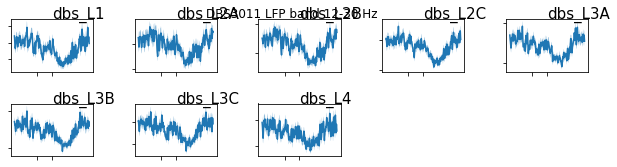

In [31]:

fig, axs = plt.subplots(ncol, nrow, figsize=(nrow*1.75, ncol*1.25))
axs = axs.flatten()
plt.tight_layout()

start_loc = 0

if len(dbs_chan)> 0:
    for elec in range(dbs_mat.shape[1]):
        elec_mat = dbs_mat[:, elec]
        elec_mat = elec_mat[~np.all(elec_mat == 0, axis=1)]
        mean = elec_mat.mean(axis=0)
        sem = nansem(elec_mat, axis=0)
        axs[elec + start_loc].plot(xvals, mean)
        axs[elec + start_loc].fill_between(xvals, mean-sem, mean+sem, alpha=0.5)
        axs[elec + start_loc].set(yticklabels=[], xticklabels=[], xticks=[0, 1])
        axs[elec + start_loc].text(0.5, 1, chanlabel[dbs_chan][elec], 
                                   transform=axs[elec + start_loc].transAxes, fontsize=15)
start_loc += dbs_mat.shape[1]
for i in range(start_loc, ncol*nrow):
    sns.despine(top=True, right=True, left=True, bottom=True, ax=axs[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.suptitle(SUBJECT + f" LFP band {f_low}-{f_high} Hz");

In [33]:

dbs_chan
chanlabel

array([68, 69, 70, 71, 72, 73, 74, 75])

array(['ecog_101', 'ecog_102', 'ecog_103', 'ecog_104', 'ecog_105',
       'ecog_106', 'ecog_107', 'ecog_108', 'ecog_109', 'ecog_110',
       'ecog_111', 'ecog_112', 'ecog_113', 'ecog_114', 'ecog_115',
       'ecog_116', 'ecog_117', 'ecog_118', 'ecog_119', 'ecog_120',
       'ecog_121', 'ecog_122', 'ecog_123', 'ecog_124', 'ecog_125',
       'ecog_126', 'ecog_127', 'ecog_128', 'ecog_129', 'ecog_130',
       'ecog_131', 'ecog_132', 'ecog_133', 'ecog_134', 'ecog_135',
       'ecog_136', 'ecog_137', 'ecog_138', 'ecog_139', 'ecog_140',
       'ecog_141', 'ecog_142', 'ecog_143', 'ecog_144', 'ecog_145',
       'ecog_146', 'ecog_147', 'ecog_148', 'ecog_149', 'ecog_150',
       'ecog_151', 'ecog_152', 'ecog_153', 'ecog_154', 'ecog_155',
       'ecog_156', 'ecog_157', 'ecog_158', 'ecog_159', 'ecog_160',
       'ecog_161', 'ecog_162', 'ecog_163', 'V0_con4a', 'ecog_201',
       'ecog_202', 'ecog_203', 'ecog_204', 'dbs_L1', 'dbs_L2A', 'dbs_L2B',
       'dbs_L2C', 'dbs_L3A', 'dbs_L3B', 'dbs_L3C', 'db

In [34]:
chanlabel[dbs_chan]

array(['dbs_L1', 'dbs_L2A', 'dbs_L2B', 'dbs_L2C', 'dbs_L3A', 'dbs_L3B',
       'dbs_L3C', 'dbs_L4'], dtype='<U10')

In [33]:
dbs_mat[:, elec].shape

(220, 5000)

In [32]:
elec_mat.mean(axis=0).shape

(5000,)